In [4]:
import queue
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
import pyroomacoustics as pra
from scipy.io import wavfile

In [472]:
# define constants
nfft = 1024
Fs = 44100
channels = 8
flow = 500
fhigh = 1000
array_loc = [0, 0]
max_sources = 1
source_thresh = 10**19.2
numgridpoints = 12
blocksize = nfft
angle_jump_threshold = 90

In [451]:
# read in signals from gridpoints
audio_file_path = "/Users/nharrison/DOA_Testing/"
signals = []
ground_azs = np.zeros(numgridpoints)
recovered_azs = []
powers = []
starts = np.zeros(numgridpoints,dtype = int)
ends = np.zeros(numgridpoints,dtype=int)
for gridindex in range(numgridpoints):
    for signalindex in range(1,channels+1):
        x = -(gridindex%3)
        y = gridindex//3+1
        if x == 0:
            ground_azs[gridindex] = np.pi/2*180/np.pi
        else:
            ground_azs[gridindex] = np.arctan(-x/y)*180/np.pi+90
        file = audio_file_path + "y="+str(y)+",x="+str(x)+"/"+str(signalindex) + ".wav"
        fs, signal = wavfile.read(file)
        if signalindex == 1:
            signals.append(np.zeros((channels, len(signal))))

        signals[gridindex][signalindex-1, :] = signal
    numsamples = signals[gridindex].shape[1]
    numblocks = numsamples//blocksize
    recovered_azs.append(np.zeros(numblocks))
    powers.append(np.zeros(numblocks))

#print(ground_azs)

/var/folders/4t/rx6h__y129d95fxhwcb9st6w0000gn/T/ipykernel_4891/2751006211.py:18: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, signal = wavfile.read(file)


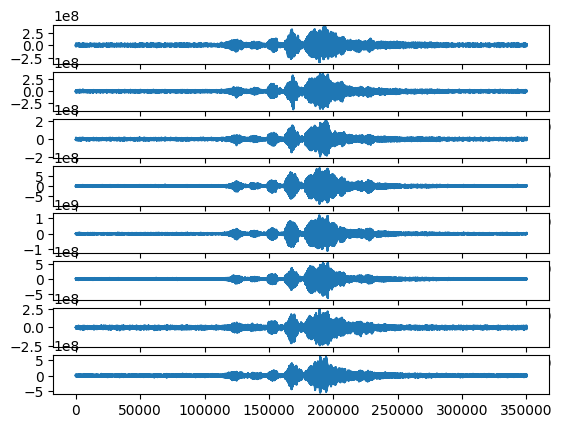

In [436]:
fig = plt.figure()
axes = []
gs = fig.add_gridspec(8,1)
for i in range(channels):
    axes.append(fig.add_subplot(gs[i,0]))
    axes[i].plot(signals[0][i,:])
    

In [473]:
# Initialise DOA Object
freq_range = [flow,fhigh]
freq_range = [int(np.round(f / Fs * nfft)) for f in freq_range] 
freq_bins = np.arange(freq_range[0], freq_range[1], dtype=np.int64)

candidate_azs = np.linspace(0, 180, 181)

mic_positions = np.array([[1.05,0.75,0.45,0.15,-0.15,-0.45,-0.75,-1.05],[0]*channels])
music = pra.doa.normmusic.NormMUSIC(mic_positions, Fs, nfft,num_src=max_sources,azimuth = candidate_azs*np.pi/180,mode='near')
music.freq_bins = freq_bins



In [455]:

def process(indata,gridindex,block_index):
	global recovered_azs, active, detection
    # STFT and determine no. of sources

	# get source power from eig subspace decomp
	X = pra.transform.stft.analysis(indata.T, nfft, nfft//2).T
	C_hat = music._compute_correlation_matricesvec(X)
	Es,En,ws,wn = music._subspace_decomposition(C_hat[None,...])
	ws = np.squeeze(ws,axis=0)
	current = np.mean(ws, axis=0)
	
	if block_index == 0:
		powers[gridindex][block_index] = current
	else:
		powers[gridindex][block_index] = 0.95*powers[gridindex][block_index-1]+0.05*current
	
	# apply threshold

	if powers[gridindex][block_index] > source_thresh:
		if active == False:
			starts[gridindex] = block_index
		active = True
		
	else:
		if active == True:
			ends[gridindex] = block_index
		active = False
	if active:
		music.locate_sources(X,freq_bins=freq_bins)
		az = music.azimuth_recon*180/np.pi
		prev_az = recovered_azs[gridindex][block_index-1]
		if prev_az == 0:
			pass
		elif abs(az-prev_az)>angle_jump_threshold:
			az = prev_az
		else:
			az = 0.9*prev_az+0.1*az
	else:
		az = 0
	return az
	

In [439]:

numsamples = signals.shape[1]
numblocks = numsamples//blocksize
#print(numsamples)
#print(numblocks)

source_powers = np.zeros(numblocks)
azs = np.zeros(numblocks)

for block_index in range(numblocks):
    package = signals[:,block_index*blocksize:(block_index+1)*blocksize]
    process(package,block_index)

#print(source_powers)


AttributeError: 'list' object has no attribute 'shape'

ValueError: x and y must have same first dimension, but have shapes (64,) and (33,)

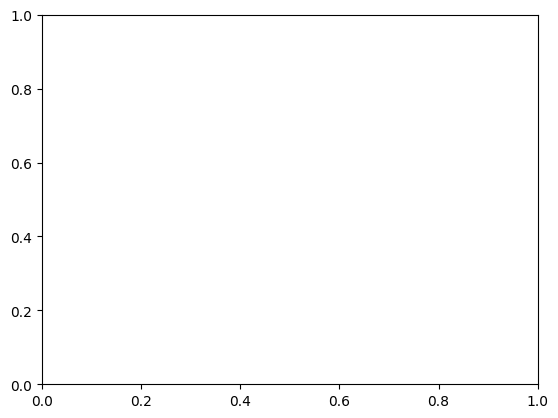

In [262]:
fig = plt.figure()
axes = []
gs = fig.add_gridspec(1,1)
ax = fig.add_subplot(gs[0,0])

ax.plot(np.arange(numblocks)*blocksize,azs)
    

In [474]:


for gridindex in range(numgridpoints):
    numsamples = signals[gridindex].shape[1]
    numblocks = numsamples//blocksize
    active = False
    for block_index in range(numblocks):       
        package = signals[gridindex][:,block_index*blocksize:(block_index+1)*blocksize]
        recovered_azs[gridindex][block_index] = process(package,gridindex,block_index)
    

/var/folders/4t/rx6h__y129d95fxhwcb9st6w0000gn/T/ipykernel_4891/1255505194.py:7: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.arange(recovered_azs[gridindex].shape[0])[starts[gridindex]:ends[gridindex]]*blocksize,np.log10(powers[gridindex])[starts[gridindex]:ends[gridindex]])


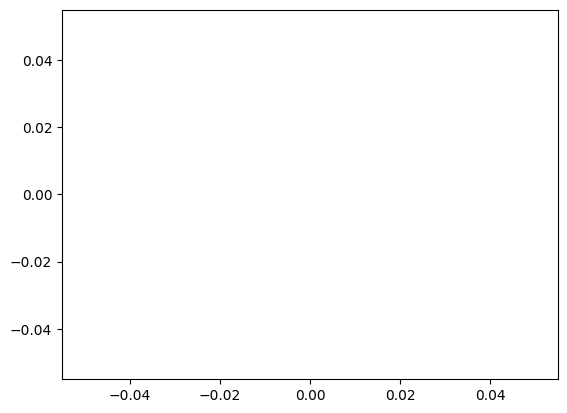

In [452]:
fig = plt.figure()
axes = []
gs = fig.add_gridspec(1,1)
ax = fig.add_subplot(gs[0,0])

for gridindex in range(4):
    ax.plot(np.arange(recovered_azs[gridindex].shape[0])*blocksize,np.log10(powers[gridindex]))

[121  83 180 118 117  45 105 120 101  83 110 150]
Grid Point 1, Ground Truth Azimuth: 90.0, Average Recovered Azimuth: 85.85274902372947, Error: 4.147250976270527
Grid Point 2, Ground Truth Azimuth: 135.0, Average Recovered Azimuth: 92.79178176382261, Error: 42.20821823617739
Grid Point 3, Ground Truth Azimuth: 153.43494882292202, Average Recovered Azimuth: 116.35339127653002, Error: 37.081557546392006


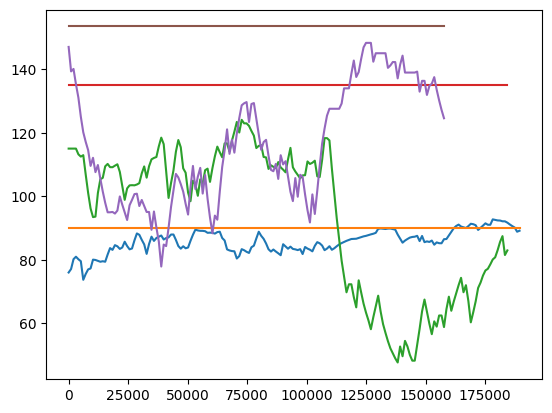

In [483]:
fig = plt.figure()
axes = []
gs = fig.add_gridspec(1,1)
ax = fig.add_subplot(gs[0,0])
print(starts)

for gridindex in range(0,3):
    average_recovered = np.mean(recovered_azs[gridindex][starts[gridindex]:ends[gridindex]])
    print(f"Grid Point {gridindex+1}, Ground Truth Azimuth: {ground_azs[gridindex]}, Average Recovered Azimuth: {average_recovered}, Error: {ground_azs[gridindex]-average_recovered}")
    ax.plot(np.arange(ends[gridindex]-starts[gridindex])*blocksize,recovered_azs[gridindex][starts[gridindex]:ends[gridindex]])
    ax.plot(np.arange(ends[gridindex]-starts[gridindex])*blocksize,ground_azs[gridindex]*np.ones(recovered_azs[gridindex].shape[0])[starts[gridindex]:ends[gridindex]])